## Imports

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import sys
import numpy as np
from torch import nn
#from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageFilter
from scipy.signal import argrelextrema
print("ok")


ok


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cpu device


## Parameters and Hyperparameters

In [4]:
num_epochs = 10
img_width = 200
img_height = 50
num_characters = 26 #TODO: change for function

## create segment

In [5]:
from utils import SplitImage

si = SplitImage("src/pmml_project/img/a01-043.png")
handwritten_area = si.handwritten_area()
handwritten_area.save('handwritten-a01-043.png')



### Create the horizontal projection of gray values

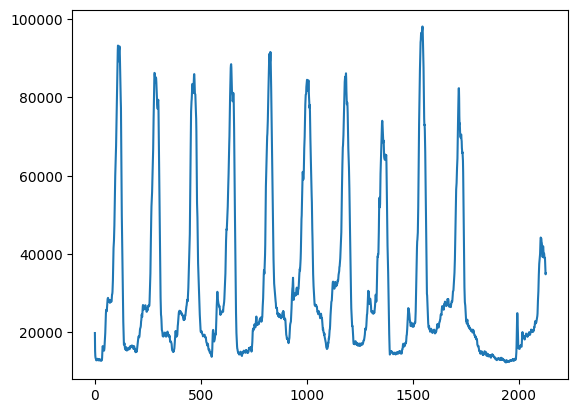

In [99]:
img = Image.open("handwritten-a01-043.png")
pixels = np.array(img)
horizontal_projection = np.sum(255 - pixels, axis=1)
plt.plot(horizontal_projection)
plt.show()

### Find local minima

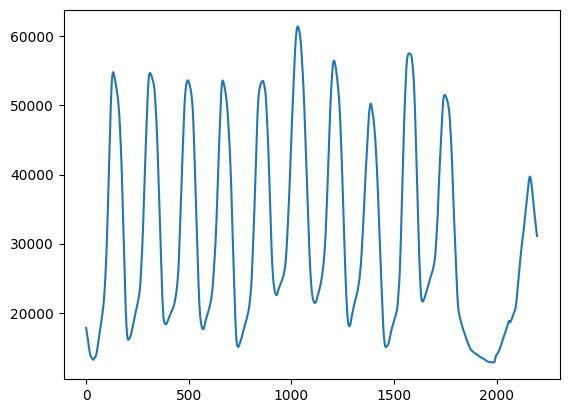

In [111]:
# code from https://www.kaggle.com/code/irinaabdullaeva/text-segmentation

def smooth(x, window_len=70, window='hanning'):
#     if x.ndim != 1:
#         raise ValueError("smooth only accepts 1 dimension arrays.") 
    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.") 
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s = np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = eval('np.'+window+'(window_len)')

    y = np.convolve(w/w.sum(),s,mode='valid')
    return y

smoothed = smooth(horizontal_projection, 70, window='flat')
plt.plot(smoothed)

local_minima = argrelextrema(smoothed, np.less)
local_minima = np.array(local_minima).flatten()

### Cropping lines

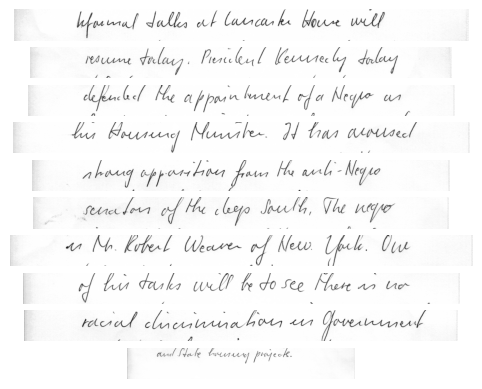

In [104]:
def crop_lines(local_minima, threshold=0):
    x1 = 0
    cropped = []
    diff = []
    for i, min in enumerate(local_minima):
        x2 = min
        #print(f"x1 = {x1}, x2 = {x2}, diff = {x2-x1}")
        if x2-x1 >= threshold:
            cropped.append((x1, x2))
        x1 = min
    return cropped

def show_cropped_lines(img, cropped):
    plots = len(cropped)
    for i, l in enumerate(cropped):
        line = img[l[0]:l[1]]
        plt.subplot(plots, 1, i+1)
        plt.axis('off')

        _ = plt.imshow(line, cmap='gray')
        plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

cropped = crop_lines(local_minima, 100)
show_cropped_lines(pixels, cropped)

In [4]:
#define nn datastructure
class OCR_dataset(Dataset):
    def __init__(self):
        pass

    def __len__(self):
        pass

    def __getitem__(self,idx):
        pass

In [5]:
#test training split
train_dataloader = DataLoader( #TODO
test_dataloader = DataLoader(
eval_dataloader = DataLoader(

_IncompleteInputError: incomplete input (4156652432.py, line 4)

In [9]:
#define nn layers
class OCR_neural_network(nn.Module):
    def __init__(self, img_width, img_height, num_characters):
        super().__init__()
        self.rnn_height = img_height//4
        self.rnn_width = img_width//4
        self.rnn_feature_number = self.rnn_height * 64
        
        self.conv_pooling_stack = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding = 1),
            nn.ReLu(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding = 1),
            nn.ReLu(),
            nn.MaxPool2d(2)
        )

        self.after_resize_stack = nn.Sequential(
            nn.Linear(self.rnn_feature_number, 64),
            nn.ReLu(),
            nn.Dropout(0.2)
        )
            
        self.rnn1 = nn.LSTM(64, 128, batch_first = True, bidirectional = True, dropout = 0.25)
        self.rnn2 = nn.LSTM(256, 64, batch_first = True, bidirectional = True, dropout = 0.25)

        self.output_layer = nn.Linear(128, num_characters)
        
        def forward(self, x):
            batch_size, seq_len, channels, height = x.size()
            
            x = self.conv_pooling_stack(x)
    
            #reshape for rnn
            x = x.permute(0, 3, 1, 2)
            x = torch.reshape(x, (batch_size, seq_len, channels * height))    
            
            x = self.after_resize_stack(x)
    
            x, y = self.rnn1(x) #y is not used
            x, y = self.rnn2(x)
    
            x = self.output_layer(x)
            return x



In [ ]:
#create instance of model
model = OCR_neural_network(img_width, img_height, num_characters)

In [ ]:
#train NN
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for 